[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfc/janus-core/blob/main/docs/source/tutorials/cli/md.ipynb)

# Molecular Dynamics

## Set up environment (optional)

These steps are required for Google Colab, but may work on other systems too:

In [1]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# ! pip uninstall torch torchaudio torchvision numpy -y
# ! uv pip install janus-core[all] data-tutorials torch==2.5.1 --system
# get_ipython().kernel.do_shutdown(restart=True)

In [2]:
from ase.build import bulk
from ase.io import read, write
from weas_widget import WeasWidget
from janus_core.helpers.stats import Stats
from janus_core.processing import post_process
import yaml

import numpy as np
import matplotlib.pyplot as plt

### NVT

In ```janus_core``` we can simulate MD in various ensembles. To start we will look at a simple NVT simulation of NaCl.

Using the ASE we can build an NaCl crystal sample. Which we can look at using Weas.

In [3]:
NaCl = bulk("NaCl", "rocksalt", a=5.63, cubic=True)
NaCl = NaCl * (2, 2, 2)
write("../data/NaCl.xyz", NaCl)

v=WeasWidget()
v.from_ase(NaCl)
v

WeasWidget(children=(BaseWidget(atoms={'species': {'Na': 'Na', 'Cl': 'Cl'}, 'cell': [11.26, 0.0, 0.0, 0.0, 11.…

#### Running the simulation

For our simulation we can prepare a config YAML file for the ```janus md``` command.

Here we set the ensemble and the structure.

The following 2 options specify the simulation steps to perform in MD and the MD temperature in K. The default timestep is 1 fs.

The final 2 options set the frequency to write statistics and trajectory frames.

If you have a GPU on you, then the commented out option will speed things up considerably.

In [4]:
%%writefile config-nvt.yml

ensemble: nvt
struct: ../data/NaCl.xyz

steps: 250
temp: 100

stats_every: 10
traj_every: 10
restart_every: 50

tracker: False

# If you have an Nvidia GPU.
#device: cuda

Writing config-nvt.yml


As with other ```janus_core``` functionalities the help method will show the available options along with units

In [5]:
!janus md --help

                                                                                
 Usage: janus md [OPTIONS]                                                      
                                                                                
 Run molecular dynamics simulation, and save trajectory and statistics.         
                                                                                
╭─ Options ────────────────────────────────────────────────────────────────────╮
│ *  --ensemble                             [nph|npt|nve|nv  Name of           │
│                                           t|nvt-nh|nvt-cs  thermodynamic     │
│                                           vr|npt-mtk]      ensemble.         │
│                                                            [default: None]   │
│                                                            [required]        │
│ *  --struct                               PATH             Path of structure │
│                           

We can begin our simulation by calling the following shell command. Which may take a few minutes on a CPU.

In [6]:
! janus md --config config-nvt.yml

/Users/elliottkasoar/Documents/PSDI/janus-core/.venv/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_i

#### The outputs

While we are waiting for the simulation we can familiarise ourselves with the output files you will see.

The directory ```janus_results``` will be populated with the following key files named ```NaCl-nvt-T100.0-```

- ```stats.dat```
- ```traj.extxyz```
- ```final.extxyz```
- ```md-log.yml```
- ```md-summary.yml```

The stats file contains core statistical data on the simulation, including the step, wall-time, temperature, volume, and pressure tensor.

You could view this now while the simulation is running by the shell command

```shell
$ head janus_results/NaCl-nvt-T100.0-stats.dat 
```
Giving something like the following
```
# Step | Real_Time [s] | Time [fs] | Epot/N [eV] ...
         0 1.044          0.00 -3.37876019e+00 ...
        10 8.772         10.00 -3.37789444e+00 ...
```

The first line in the stats files also includes the units used. Temperatures are all in K, lengths in Angstroms, and Pressures in GPa.

The ```traj``` and ```final``` files including the MD trajectory and the final configuration in EXTXYZ format.

```md-log``` and ```md-summary``` give information about the running of the simulation and a summary of the options used in ```janus-md``` respectively. The latter in particular is worth a look as it also includes the default values for example the ```bulk_modulus```.

```shell
$ cat janus_results/NaCl-nvt-T100.0-md-summary.yml 
command: janus md
config:
  arch: mace_mp
  barostat_chain: 3
  barostat_substeps: 1
  barostat_time: null
  bulk_modulus: 2.0
  calc_kwargs: {}
...
```

These output files provide a full record of what you have done alongside the standard MD outputs.

### Analysing the simulation

Once the simulation has completed we can make use of the utilities in ```janus_core```. In particular ```janus_core.helpers.stats.Stats``` which makes viewing the ```stats.dat``` file straightforward (alternatively the file is readable by ```np.loadtxt```).

Passing the path to our statistics we can observe the temperature, volume, and pressure resulting from the potential in NVT.

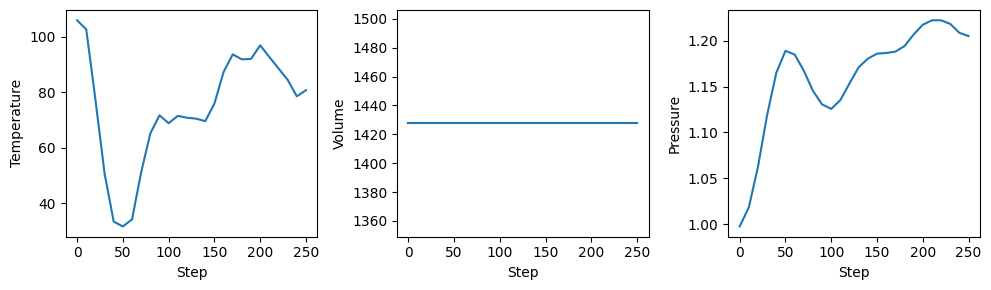

In [7]:
stats = Stats("janus_results/NaCl-nvt-T100.0-stats.dat")
fig, ax = plt.subplots(ncols=3, figsize=(10,3))
ax[0].plot(stats[0], stats[5])
ax[0].set_xlabel("Step")
ax[0].set_ylabel("Temperature")

ax[1].plot(stats[0], stats[8])
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Volume")

ax[2].plot(stats[0], stats[9])
ax[2].set_xlabel("Step")
ax[2].set_ylabel("Pressure")
plt.tight_layout()

Since we have been saving the trajectory every 10 steps we can also see a nice movie of our computers labour.

In [8]:
traj = read("janus_results/NaCl-nvt-T100.0-traj.extxyz", index=":")
v=WeasWidget()
v.from_ase(traj)
v.avr.model_style = 1
v.avr.show_hydrogen_bonds = True
v

WeasWidget(children=(BaseWidget(atoms=[{'species': {'Na': 'Na', 'Cl': 'Cl'}, 'cell': [11.26, 0.0, 0.0, 0.0, 11…

Another helper provided in ```janus_core``` is the post processing module ```from janus_core.processing.post_process```. This enables velocity auto-correlation function and radial distribution function computation from trajectory files.

Using our data we can take a look at the RDF, and VAF

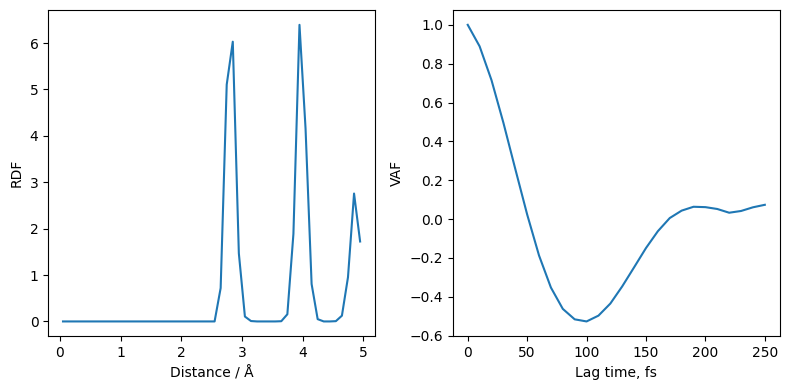

In [9]:
rdf = post_process.compute_rdf(traj, rmax=5.0, nbins=50)
vaf = post_process.compute_vaf(traj)

fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].plot(rdf[0], rdf[1])
ax[0].set_ylabel("RDF")
ax[0].set_xlabel("Distance / Å")

ax[1].plot(vaf[0]*10, vaf[1][0]/vaf[1][0][0])
ax[1].set_ylabel("VAF")
ax[1].set_xlabel("Lag time, fs")

plt.tight_layout()

### Continuing the simulation

Using the final configuration we can continue the simulation easily. We can make use of our old config but override some of the values manually.

Here we indicate we want to restart with ```--restart```, and pass our parameters from before via ```--config```. ```janus_core``` will find our old files and begin dynamics again from the last restart file. For us this happens to be at step 250. Because we override the steps with ```--steps 300``` we get an additional 50 simulation steps appended to our statistics and trajectory files.

In [10]:
! janus md --restart --steps 300 --config config-nvt.yml

/Users/elliottkasoar/Documents/PSDI/janus-core/.venv/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_i

Text(0, 0.5, 'Temperature')

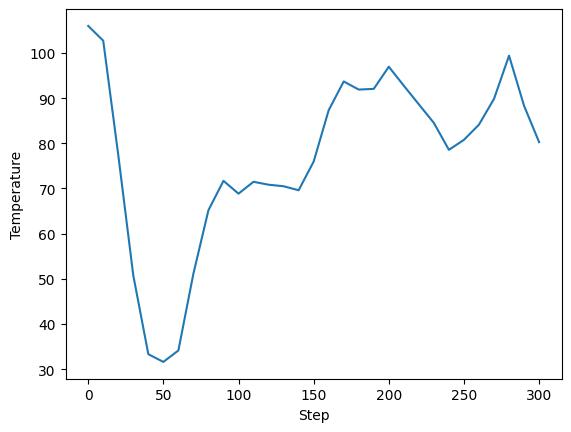

In [11]:
stats = Stats("janus_results/NaCl-nvt-T100.0-stats.dat")
fig, ax = plt.subplots()
ax.plot(stats[0], stats[5])
ax.set_xlabel("Step")
ax.set_ylabel("Temperature")

### Correlations at runtime

Alongside post-processing of trajectory files ```janus_core``` includes a correlations module to calculate correlation functions at runtime that do not require trajectory storage.

For example beginning again from our initial structure we can compute the VAF online with the addition of correlation_kwargs.

In these options we specify a list of correlations $\langle a b \rangle$ to compute. First the VAF by requesting a correlation with ```Velocity``` as the quantity $a$ ($b$ is assumed to be the same if not set) up to $250$ correlation points (lag times). Additionally we also create a stress auto-correlation function by forming a second correlation with ```Stress```. In this we also set the stress components to be correlated over, again $b$ left unspecified means it is the same as a. These extra settings will give us the correlation function $\frac{1}{3}(\langle \sigma_{xy}\sigma_{xy}\rangle+\langle \sigma_{yz}\sigma_{yz}\rangle+\langle \sigma_{zx}\sigma_{zx}\rangle)$.

By default a correlation is updated every step. This can be controlled by the option ```update_frequency```.

In [12]:
%%writefile config-nvt-cor.yml

ensemble: nvt
struct: ../data/NaCl.xyz

steps: 250
temp: 100

stats_every: 10
traj_every: 250

correlation_kwargs:
  vaf:
    a: Velocity
    points: 250
  saf:
    a: Stress
    a_kwargs: {'components': ['xy', 'yz', 'zx']}
    points: 250

tracker: False

# If you have an Nvidia GPU.
#device: cuda

Writing config-nvt-cor.yml


In [13]:
! janus md --config config-nvt-cor.yml

/Users/elliottkasoar/Documents/PSDI/janus-core/.venv/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_i

### Analysing correlations

We can load up the new file ```NaCl-nvt-T100.0-cor.dat``` which contains the correlation function we asked for in a YAML format.

Previously we computed the VAF using the trajectory saved every 10 frames, our result here will be more accurate at the expense of a longer runtime, but we do not require any trajectory data.

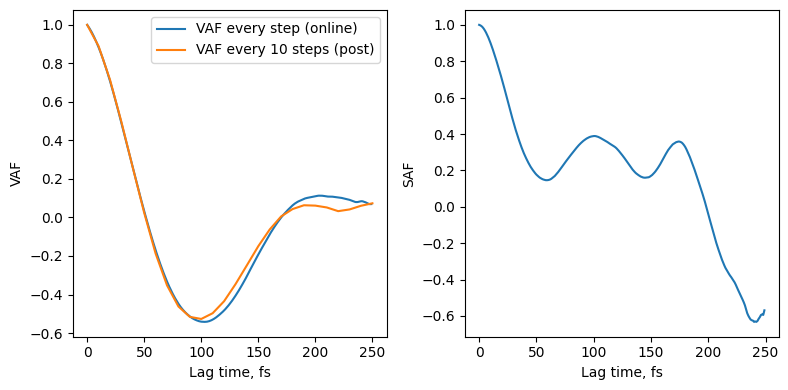

In [14]:
with open("janus_results/NaCl-nvt-T100.0-cor.dat", "r") as cor:
    data = yaml.safe_load(cor)
    vaf = data["vaf"]
    saf = data["saf"]

fig, ax = plt.subplots(ncols=2, figsize=(8,4))

ax[0].plot(vaf['lags'], np.array(vaf['value'])/vaf['value'][0], label="VAF every step (online)")
ax[0].set_ylabel("VAF")
ax[0].set_xlabel("Lag time, fs")

vaf_post = post_process.compute_vaf(traj)

ax[0].plot(vaf_post[0]*10, vaf_post[1][0]/vaf_post[1][0][0], label="VAF every 10 steps (post)")
ax[0].set_ylabel("VAF")
ax[0].set_xlabel("Lag time, fs")

ax[0].legend()

ax[1].plot(saf['lags'], np.array(saf['value'])/saf['value'][0])
ax[1].set_ylabel("SAF")
ax[1].set_xlabel("Lag time, fs")

plt.tight_layout()

### Heating

```janus_core``` has a facility for heating or cooling during MD. This is controlled by 4 options.

- ```temp_start```: the starting temperature in Kelvin.
- ```temp_end```: the final temperature in Kelvin.
- ```temp_step```: the temperature increment in Kelvin.
- ```temp_time```: the number of time steps at each temperature increment.

In this context the options ```temp``` and ```steps``` will apply in a normal MD run after the heating has finished.

We can make use of this to perform a naive estimation of melting in NPT by progressively increasing temperature. To keep the cell angles fixed we also apply a mask via ``ensemble_kwargs``` which are passed to ASE's thermo-/baro-stats.

We are going to cheat by using a pre-prepared structure ```NaCl-1070.extxyz```. This was equilibrated from ```../data/NaCl.xyz``` in a similar way that we are about to continue but over many more steps. We can have a quick look at our starting point.

In [15]:
v=WeasWidget()
structure = read("../data/NaCl-1040.extxyz")
structure.wrap()
v.from_ase(structure)
v

WeasWidget(children=(BaseWidget(atoms={'species': {'Na': 'Na', 'Cl': 'Cl'}, 'cell': [13.29106810939046, 0.0, 0…

We add in our heating parameters and npt options in a new config and run it.

In [16]:
%%writefile config-npt-heat.yml

ensemble: npt
ensemble_kwargs:
  mask: [[1,0,0],[0,1,0],[0,0,1]]

struct: ../data/NaCl-1040.extxyz

temp_start: 1040
temp_end: 1080
temp_step: 5
temp_time: 25

stats_every: 10
traj_every: 10

tracker: False

# If you have an Nvidia GPU.
#device: cuda

Writing config-npt-heat.yml


In [17]:
! janus md --config config-npt-heat.yml

/Users/elliottkasoar/Documents/PSDI/janus-core/.venv/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_i

In [18]:
v=WeasWidget()
structure = read("janus_results/NaCl-1040-npt-T1040.0-T1080.0-p0.0-final.extxyz")
structure.wrap()
v.from_ase(structure)
v

WeasWidget(children=(BaseWidget(atoms={'species': {'Na': 'Na', 'Cl': 'Cl'}, 'cell': [12.064160348359595, 0.0, …

### Extensions

#### Viscosity

Simulate liquid NaCl in NVE at about 1080 K and calculate the SAF as we have done before. Use the SAF to estimate the viscosity $\eta = \frac{V}{3k_{b}T}\int \langle \sigma_{xy}\sigma_{xy}\rangle+ \langle \sigma_{yz}\sigma_{yz}\rangle+ \langle \sigma_{zx}\sigma_{zx}\rangle dt$. Experimentally the viscosity is $1.030$ mN s m ${}^{-2}$ [1]. Long simulations and repeats are required for accuracy, but try 1000 fs.

You will find the pre-equilibrated structure ```NaCl-1040.xyz``` useful!

[1] Janz, G.J., 1980. Molten salts data as reference standards for density, surface tension, viscosity, and electrical conductance: KNO3 and NaCl. Journal of physical and chemical reference data, 9(4), pp.791-830.

#### Melting

Try heating the NaCl crystal ```../data/NaCl.xyz``` up to 1080 K using the temperature ramp options in NPT. To keep cell angles constant, you will want to add the options

```
ensemble_kwargs:
  mask: [[1,0,0],[0,1,0],[0,0,1]]
```
```temp_time: 2000``` would be good if you have a GPU. You can also "cheat" by staring from ```NaCl-1000.xyz```

Experimentally NaCl melts at about 1074 Kelvin at atmospheric pressure.